In [30]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from dgtv.dgtv import *

In [2]:
data = scipy.io.loadmat('thorax.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: LNX86, Created on: Thu Jul 31 14:24:40 1997',
 '__version__': '1.0',
 '__globals__': [],
 'thorax': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)}

In [3]:
print(data['thorax'].shape)

(512, 512)


In [4]:
image_data = data['thorax']

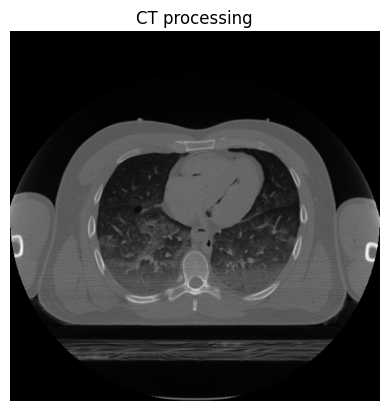

In [12]:
def pltimg(img):
    plt.imshow(img, cmap='gray')  # 'cmap' là màu sắc của hình ảnh (ở đây là xám)
    plt.axis('off')  # Tắt trục số
    plt.title('CT processing')
    plt.show()
pltimg(image_data)
plt.imsave('dataset/dataset_structure/torso1.png',image_data,cmap='gray')


In [31]:
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.signal import fftconvolve
from bm3d import gaussian_kernel
from PIL import Image


In [12]:
! pip install bm3d

Defaulting to user installation because normal site-packages is not writeable


In [32]:
def get_psnr(y_est: np.ndarray, y_ref: np.ndarray) -> float:
    """
    Return PSNR value for y_est and y_ref presuming the noise-free maximum is 1.
    :param y_est: Estimate array
    :param y_ref: Noise-free reference
    :return: PSNR value
    """
    return 10 * np.log10(1 / np.mean(((y_est - y_ref).ravel()) ** 2))

In [33]:
def get_cropped_psnr(y_est: np.ndarray, y_ref: np.ndarray, crop: tuple) -> float:
    """
    Return PSNR value for y_est and y_ref presuming the noise-free maximum is 1.
    Crop the images before calculating the value by crop.
    :param y_est: Estimate array
    :param y_ref: Noise-free reference
    :param crop: Tuple of crop-x and crop-y from both stides
    :return: PSNR value
    """
    return get_psnr(np.atleast_3d(y_est)[crop[0]:-crop[0], crop[1]:-crop[1], :],
                    np.atleast_3d(y_ref)[crop[0]:-crop[0], crop[1]:-crop[1], :])

In [34]:
def get_experiment_kernel(noise_type: str, noise_var: float, sz: tuple = np.array((101, 101))):
    """
    Get kernel for generating noise from specific experiment from the paper.
    :param noise_type: Noise type string, g[0-4](w|)
    :param noise_var: noise variance
    :param sz: size of image, used only for g4 and g4w
    :return: experiment kernel with the l2-norm equal to variance
    """
    # if noiseType == gw / g0
    kernel = np.array([[1]])
    noise_types = ['gw', 'g0', 'g1', 'g2', 'g3', 'g4', 'g1w', 'g2w', 'g3w', 'g4w']
    if noise_type not in noise_types:
        raise ValueError("Noise type must be one of " + str(noise_types))

    if noise_type != "g4" and noise_type != "g4w":
        # Crop this size of kernel when generating,
        # unless pink noise, in which
        # if noiseType == we want to use the full image size
        sz = np.array([101, 101])
    else:
        sz = np.array(sz)

    # Sizes for meshgrids
    sz2 = -(1 - (sz % 2)) * 1 + np.floor(sz / 2)
    sz1 = np.floor(sz / 2)
    uu, vv = np.meshgrid([i for i in range(-int(sz1[0]), int(sz2[0]) + 1)],
                         [i for i in range(-int(sz1[1]), int(sz2[1]) + 1)])

    beta = 0.8

    if noise_type[0:2] == 'g1':
        # Horizontal line
        kernel = np.atleast_2d(16 - abs(np.linspace(1, 31, 31) - 16))

    elif noise_type[0:2] == 'g2':
        # Circular repeating pattern
        scale = 1
        dist = uu ** 2 + vv ** 2
        kernel = np.cos(np.sqrt(dist) / scale) * gaussian_kernel((sz[0], sz[1]), 10)

    elif noise_type[0:2] == 'g3':
        # Diagonal line pattern kernel
        scale = 1
        kernel = np.cos((uu + vv) / scale) * gaussian_kernel((sz[0], sz[1]), 10)

    elif noise_type[0:2] == 'g4':
        # Pink noise
        dist = uu ** 2 + vv ** 2
        n = sz[0] * sz[1]
        spec = (np.sqrt((np.sqrt(n) * 1e-2) / (np.sqrt(dist) + np.sqrt(n) * 1e-2)))
        kernel = fftshift(ifft2(ifftshift(spec)))

    else:  # gw and g0 are white
        beta = 0

    # -- Noise with additional white component --

    if len(noise_type) > 2 and noise_type[2] == 'w':
        kernel = kernel / np.sqrt(np.sum(kernel ** 2))
        kalpha = np.sqrt((1 - beta) + beta * abs(fft2(kernel, (sz[0], sz[1]))) ** 2)
        kernel = fftshift(ifft2(kalpha))

    kernel = np.real(kernel)
    # Correct variance
    kernel = kernel / np.sqrt(np.sum(kernel ** 2)) * np.sqrt(noise_var)

    return kernel

In [35]:
def get_experiment_noise(noise_type: str, noise_var: float, realization: int, sz: tuple)\
        -> (np.ndarray, np.ndarray, np.ndarray):
    """
    Generate noise for experiment with specified kernel, variance, seed and size.
    Return noise and relevant parameters.
    The generated noise is non-circular.
    :param noise_type: Noise type, see get_experiment_kernel for list of accepted types.
    :param noise_var: Noise variance of the resulting noise
    :param realization: Seed for the noise realization
    :param sz: image size -> size of resulting noise
    :return: noise, PSD, and kernel
    """
    np.random.seed(realization)

    # Get pre-specified kernel
    kernel = get_experiment_kernel(noise_type, noise_var, sz)

    # Create noisy image
    half_kernel = np.ceil(np.array(kernel.shape) / 2)

    if len(sz) == 3 and half_kernel.size == 2:
        half_kernel = [half_kernel[0], half_kernel[1], 0]
        kernel = np.atleast_3d(kernel)

    half_kernel = np.array(half_kernel, dtype=int)

    # Crop edges
    noise = fftconvolve(np.random.normal(size=(sz + 2 * half_kernel)), kernel, mode='same')
    noise = np.atleast_3d(noise)[half_kernel[0]:-half_kernel[0], half_kernel[1]:-half_kernel[1], :]

    psd = abs(fft2(kernel, (sz[0], sz[1]), axes=(0, 1))) ** 2 * sz[0] * sz[1]

    return noise, psd, kernel

In [36]:
from PIL import Image

imagepath = 'dataset/dataset_structure'
imagename = imagepath + '/torso3.png' 
y = np.array(Image.open(imagename)) / 255
y.shape

(512, 512, 3)

In [24]:
image = Image.open(imagename)

# Kích thước mới
new_width = 512
new_height = 512

# Tạo một ảnh mới với kích thước mới và nền màu đen
new_image = Image.new("RGB", (new_width, new_height), (0, 0, 0))

# Đặt ảnh gốc vào giữa ảnh mới
left = (new_width - image.width) // 2
top = (new_height - image.height) // 2
new_image.paste(image, (left, top))

# Lưu ảnh mới
new_image.save("torso3.png")

# Đóng ảnh gốc
image.close()


In [42]:
# imagepath = 'dataset/dataset_structure'
# imagename = imagepath + '/ref/1.png'
# Load noise-free image
# y = Image.open(imagename).convert('L')
# y = np.array(y)
# print(y.shape)
# Possible noise types to be generated 'gw', 'g1', 'g2', 'g3', 'g4', 'g1w',
# 'g2w', 'g3w', 'g4w'.
noise_type = 'g4'
sigma = 10
noise_var = (sigma/255)**2  # Noise variance 25 std
seed = 8  # seed for pseudorandom noise realization

# Generate noise with given PSD
noise, psd, kernel = get_experiment_noise(noise_type, noise_var, seed, (512,512))
# N.B.: For the sake of simulating a more realistic acquisition scenario,
# the generated noise is *not* circulant. Therefore there is a slight
# discrepancy between PSD and the actual PSD computed from infinitely many
# realizations of this noise with different seeds.

# Generate noisy image corrupted by additive spatially correlated noise
# with noise power spectrum PSD
# z = np.atleast_3d(y) + np.atleast_3d(noise)

print(y.shape)
print(noise.shape)
z = y + noise
print(z.shape)
z_rang = np.minimum(np.maximum(z, 0), 1)
print(z_rang.shape)
# imagepath = 'dataset/Hoang/'
imagepath = 'dataset/C/noisy/'
noisyimagename=imagepath + '/12.png'
plt.imsave(noisyimagename, z_rang, cmap='gray') 
#y_est = np.array(Image.open(noisyimagename)) / 255
# Call BM3D With the default settings.
#y_est = bm3d_rgb(z, psd)

# To include refiltering:
# y_est = bm3d_rgb(z, psd, 'refilter');

# For other settings, use BM3DProfile.
# profile = BM3DProfile(); # equivalent to profile = BM3DProfile('np');
# profile.gamma = 6;  # redefine value of gamma parameter
# y_est = bm3d_rgb(z, psd, profile);

# Note: For white noise, you may instead of the PSD
# also pass a standard deviation
# y_est = bm3d_rgb(z, sqrt(noise_var));

# If the different channels have varying PSDs, you can supply a MxNx3 PSD or a list of 3 STDs:
# y_est = bm3d_rgb(z, np.concatenate((psd1, psd2, psd3), 2))
# y_est = bm3d_rgb(z, [sigma1, sigma2, sigma3])

# psnr = get_psnr(y, y_est)
# print("PSNR:", psnr)

# # PSNR ignoring 16-pixel wide borders (as used in the paper), due to refiltering potentially leaving artifacts
# # on the pixels near the boundary of the image when noise is not circulant
# psnr_cropped = get_cropped_psnr(y, y_est, [16, 16])
# print("PSNR cropped:", psnr_cropped)

(512, 512, 3)
(512, 512, 1)
(512, 512, 3)
(512, 512, 3)


In [33]:
from torch.utils.data import Dataset, DataLoader
import os 

In [34]:
def patch_splitting(dataset, output_dst, patch_size=36, stride=18):
    """Split each image in the dataset to patch size with size patch_size x patch_size
    dataset: path of full size reference images    
    """
    import matplotlib.pyplot as plt
    output_dst_temp = os.path.join(output_dst, "patches")
    output_dst_noisy = os.path.join(output_dst_temp, "noisy")
    output_dst_ref = os.path.join(output_dst_temp, "ref")
    mkdir(output_dst_temp)
    mkdir(output_dst_noisy)
    mkdir(output_dst_ref)

    dataloader = DataLoader(dataset, batch_size=1)
    total = 0
    patch_size = int(patch_size)
    stride = int(stride)
    for i_batch, s in enumerate(dataloader):
        T1 = (
            s["nimg"]
            .unfold(2, patch_size, stride)
            .unfold(3, patch_size, stride)
            .reshape(1, 3, -1, patch_size, patch_size)
            .squeeze()
        )
        T2 = (
            s["rimg"]
            .unfold(2, patch_size, stride)
            .unfold(3, patch_size, stride)
            .reshape(1, 3, -1, patch_size, patch_size)
            .squeeze()
        )
        print(i_batch, dataset.nimg_name[i_batch], T1.shape)
        img_name = dataset.nimg_name[i_batch].split(".")[0]
        img_ext = dataset.nimg_name[i_batch].split(".")[1]
        for i in range(T1.shape[1]):
            img = T1[:, i, :, :].cpu().detach().numpy().astype(np.uint8)
            img = img.transpose(1, 2, 0)
            plt.imsave(
                os.path.join(
                    output_dst_noisy, "{0}_{1}.{2}".format(img_name, i, img_ext)
                ),
                img,
            )
            total += 1
        for i in range(T2.shape[1]):
            img = T2[:, i, :, :].cpu().detach().numpy().astype(np.uint8)
            img = img.transpose(1, 2, 0)
            plt.imsave(
                os.path.join(
                    output_dst_ref, "{0}_{1}.{2}".format(img_name, i, img_ext)
                ),
                img,
            )
    print("total: ", total)

In [35]:
import torchvision.transforms as transforms

In [36]:
class OPT:
    def __init__(
        self,
        batch_size=100,
        width=36,
        connectivity="8",
        channels=3,
        u_max=100,
        u_min=10,
        lr=1e-4,
        momentum=0.99,
        ver=None,
        train="gauss_batch",
        cuda=False,
        logger=None,
        legacy=False
    ):
        self.batch_size = batch_size
        self.legacy = legacy
        self.width = width
        self.edges = 0
        self.nodes = width ** 2
        self.I = None
        self.pairs = None
        self.H = None
        self.connectivity = connectivity
        self.channels = channels
        self.lr = lr
        self.momentum = momentum
        self.u_max = u_max
        self.u_min = u_min
        self.ver = ver
        self.D = None
        self.train = train
        self.cuda = cuda
        if cuda:
            self.dtype = torch.cuda.FloatTensor
        else:
            self.dtype = torch.FloatTensor
        self.logger = logger

    def _print(self):
        self.logger.info(
            "batch_size = {0}, width = {1}, channels = {2}, u_min = {3}, u_max = {4}, lr = {5}, momentum = {6}".format(
                self.batch_size,
                self.width,
                self.channels,
                self.u_min,
                self.u_max,
                self.lr,
                self.momentum,
            )
        )

In [37]:
opt = OPT(
    batch_size=32,
    channels=3,
    lr=1e-4,
    momentum=0.9,
    u_max=1000,
    u_min=0.0001,
    cuda=True if torch.cuda.is_available() else False
)

In [38]:
dataset = RENOIR_Dataset(
        img_dir="dataset/dataset_structure",
        transform=transforms.Compose([standardize(normalize=False), ToTensor()]),
        subset=None,
    )
patch_splitting(
    dataset=dataset, output_dst="tmp", patch_size=36, stride=36 / 2
)

0 1.png torch.Size([3, 729, 36, 36])
1 2.png torch.Size([3, 729, 36, 36])
2 3.png torch.Size([3, 729, 36, 36])
3 4.png torch.Size([3, 729, 36, 36])
total:  2916


In [48]:
!python train_dgtv.py --batch 32 --lr 1e-4 --umin 0.001 --umax 1000 -m model/DGTV.pkl --epoch 50 --train tmp/patches/ --width 36 

Train DGTV
train_dgtv.py --batch 32 --lr 1e-4 --umin 0.001 --umax 1000 -m model/DGTV.pkl --epoch 50 --train tmp/patches/ --width 36
CUDA: False
tmp/patches/
1_0.png


Traceback (most recent call last):
  File "c:\Users\efe\OneDrive\Desktop\PBL6\Test1\deepgtv\train_dgtv.py", line 237, in <module>
    main(
  File "c:\Users\efe\OneDrive\Desktop\PBL6\Test1\deepgtv\train_dgtv.py", line 71, in main
    supporting_matrix(opt)
  File "c:\Users\efe\OneDrive\Desktop\PBL6\Test1\deepgtv\dgtv\dgtv.py", line 790, in supporting_matrix
    A[p[1], p[0]] = 1
RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.
